In [1]:
#Pkg.update("JLD")
using JLD
include("fld.jl")
using PyPlot
using CSV

┌ Info: Precompiling PyCall [438e738f-606a-5dbb-bf0a-cddfbfd45ab0]
└ @ Base loading.jl:1273
┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1273


In [3]:

Lr = .29
Lz = 1
Nr = 29*3
Nz = 160
tfinal = .5

println("Running until time $(tfinal)")
println("Size of domain in Z is $(Lz)")

T = zeros(Nr*Nz) .+ 1.0e-2
    
function sigma_func_hohlraum(t,T,Nr,Nz,Lr,Lz)
    thickness = 
    Ts = reshape(T,Nr,Nz)
    sigma = zeros(Nr,Nz) + 20.0*Ts.^-3.5
    low_fact = 1e-3
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    for i in 1:Nr
        for j in 1:Nz
            if ((rcenter[i] + dr*.5)<.12)
                sigma[i,j] = low_fact*20*Ts[i,j]^-3.5
            elseif ((abs(zcenter[j]-.5)<.2)) & ((rcenter[i] + dr*.5)<.276) 
                sigma[i,j] = low_fact*20*Ts[i,j]^-3.5
            elseif ((abs(zcenter[j]-.5)>.21)) & ((abs(zcenter[j]-.5)<.485)) & ((rcenter[i] + dr*.5)<.276)
                sigma[i,j] = low_fact*20*Ts[i,j]^-3.5
            elseif ((abs(zcenter[j]-.5)>=.485)) & ((rcenter[i] + dr*.5)<.16) 
                sigma[i,j] = low_fact*20*Ts[i,j]^-3.5
            end         
    
        end
    end
    sigma
end

function Cv_func(t,T,Nr,Nz,Lr,Lz)
    low_fact = 1e-3
    cv = zeros(Nr,Nz) + 5*0.05
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    for i in 1:Nr
        for j in 1:Nz
            if ((rcenter[i] + dr*.5)<.12)
                cv[i,j] = 5*low_fact*0.05
            elseif ((abs(zcenter[j]-.5)<.2)) & ((rcenter[i] + dr*.5)<.276) 
                cv[i,j] = 5*low_fact*0.05
            elseif ((abs(zcenter[j]-.5)>.21)) & ((abs(zcenter[j]-.5)<.485)) & ((rcenter[i] + dr*.5)<.276)
                cv[i,j] = 5*low_fact*0.05
            elseif ((abs(zcenter[j]-.5)>=.485)) & ((rcenter[i] + dr*.5)<.16)
                cv[i,j] = 5*low_fact*0.05
            end
        end
    end
    cv                 
end

function D_func(t,T,Nr,Nz,Lr,Lz,Er_tmp,sigma) 
    #larsen n=2 flux limiter
    Er = reshape(T,Nr,Nz)
    idz = Nz/Lz
    idr = Nr/Lr
    D = zeros(Nr,Nz) 
    for i in 1:Nr
        for j in 1:Nz
            gradE = zeros(2)
            if (i > 1)
                gradE[1] += (Er[i,j]-Er[i-1,j])*idr*0.5
            end
            if (i < Nr)
                gradE[1] += (Er[i+1,j]-Er[i,j])*idr*0.5
            end
            if (j > 1)
                gradE[2] += (Er[i,j]-Er[i,j-1])*idz*0.5
            end
            if (j < Nz)
                gradE[2] += (Er[i,j+1]-Er[i,j])*idz*0.5
            end
            normGradE = sqrt(gradE[1]^2 + gradE[2]^2)/(Er[i,j] + 1e-12)
            
            D[i,j] = 1.0./sqrt( (3.0*sigma[i,j])^2 + normGradE^2)
        end
    end
    D
end

function EOS(t,T,Nr,Nz,Lr,Lz)
    low_fact = 1e-3
    T_tmp = reshape(T,Nr,Nz)
    E = zeros(Nr,Nz) + T_tmp*(10*0.05)
    Cv = Cv_func(t,T,Nr,Nz,Lr,Lz)
    E = Cv.*T_tmp
    reshape(E,Nr*Nz)                 
end

function invEOS(t,T,Nr,Nz,Lr,Lz)
    E_tmp = reshape(T,Nr,Nz)
    T = zeros(Nr,Nz) + E_tmp/(10*0.05)
    Cv = Cv_func(t,T,Nr,Nz,Lr,Lz)
    reshape(E_tmp./Cv,Nr*Nz)
end

function Q_func(t,T,Nr,Nz,Lr,Lz)
    Q = zeros(Nr,Nz)
    dr = Lr/Nr
    dz = Lz/Nz
    rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
    zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)
    # keep radiation sources on for 2.5 nanoseconds because that is how long the laser is on for 
    if t <= .25
     for i in 1:Nr
        for j in 1:Nz
            if ((abs(zcenter[j]-.5)>.25)) & ((abs(zcenter[j]-.5)<.3)) & ((rcenter[i] + dr*.5)<.276) & ((rcenter[i] + dr*.5)>.23)
                # got Q value by taking 250 KJ/10^-8seconds (from graph of laser pulse) and dividing by the volume for the 
                #radiation sources and making it in units of gigajoule/cm^3/10^-8seconds
                Q[i,j] = .149
            end
        end
      end
    else
        Q = zeros(Nr,Nz)
    end
    Q
end

dr = Lr/Nr
dz = Lz/Nz
rcenter = linspace(0.5*dr, Lr-0.5*dr, Nr)
zcenter = linspace(0.5*dz, Lz-0.5*dz, Nz)

R,Z = meshgrid(rcenter,zcenter)
sig = sigma_func_hohlraum(0,T,Nr,Nz,Lr,Lz)
figure(figsize=(7,4))
pcolormesh(Z,R,(sig-0*flipdim(sig,2)))
colorbar()
show()

R,Z = meshgrid(rcenter,zcenter)
cv = Cv_func(0,T,Nr,Nz,Lr,Lz)
figure(figsize=(7,4))
pcolormesh(cv)
colorbar()
show()


E = EOS(0,T,Nr,Nz,Lr,Lz)
figure(figsize=(7,4))
pcolormesh(reshape(E,Nr,Nz))
colorbar()
show()

T_test = invEOS(0,E,Nr,Nz,Lr,Lz)
figure(figsize=(7,4))
pcolormesh(reshape(T_test,Nr,Nz))
colorbar()
show()


Running until time 0.5
Size of domain in Z is 1


UndefVarError: UndefVarError: linspace not defined

In [209]:
dt = 0.001
times, Er_t,T_t = time_dep_RT(tfinal,dt,T,zeros(Nr*Nz),D_func, sigma_func_hohlraum, Q_func,Cv_func,EOS,invEOS,
                      Nr, Nz, Lr, Lz, lower_z="vacuum", upper_z="vacuum", upper_r="refl",LOUD=-1,
    fname="crooked_pipe$(Nr)_$(Nz)_$(dt).jld");

501
Step 500, t = 0.5


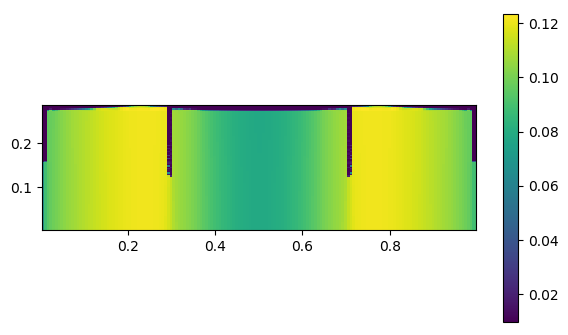

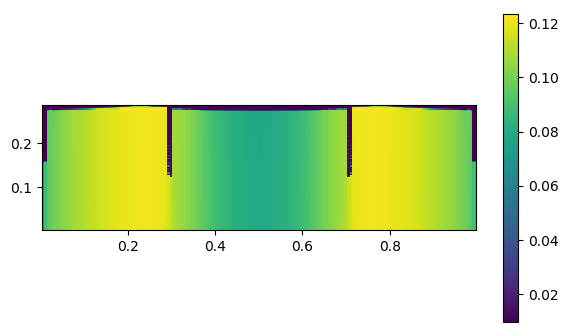

(0.003125, 0.996875, 0.0016666666666666666, 0.28833333333333333)

In [210]:
Tr_plot = reshape((Er_t[:,size(times)[1]]/a).^.25,Nr,Nz)
figure(figsize=(7,4))
pcolormesh(Z,R,Tr_plot)
colorbar()
axis("scaled")

T_plot = reshape(T_t[:,size(times)[1]],Nr,Nz)
figure(figsize=(7,4))
pcolormesh(Z,R,T_plot)
colorbar()
ylim(0,4)
xlim(0,7)
axis("scaled")

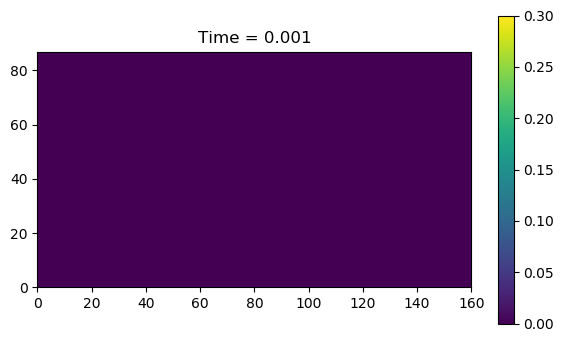

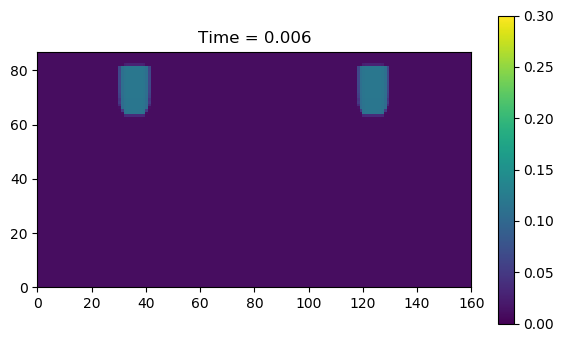

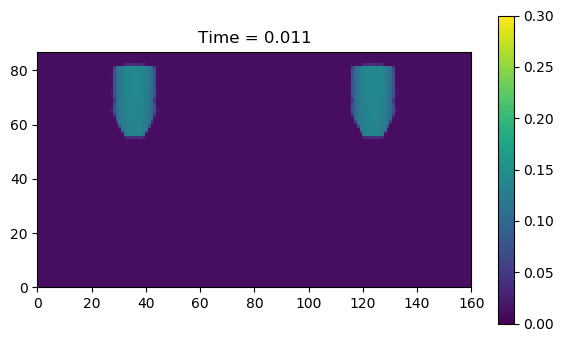

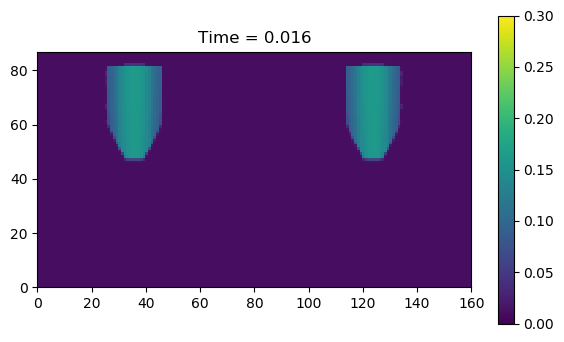

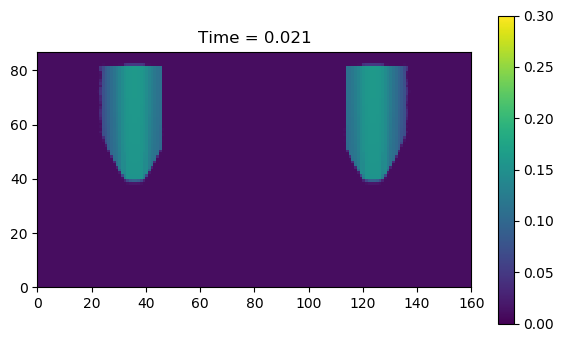

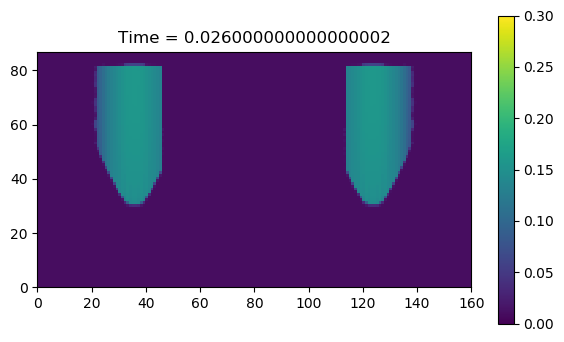

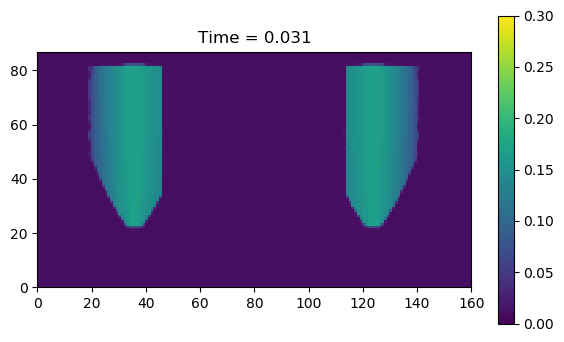

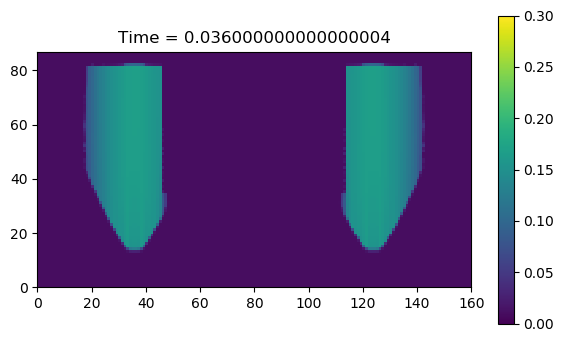

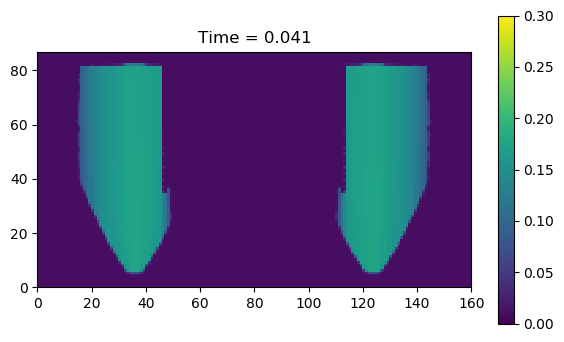

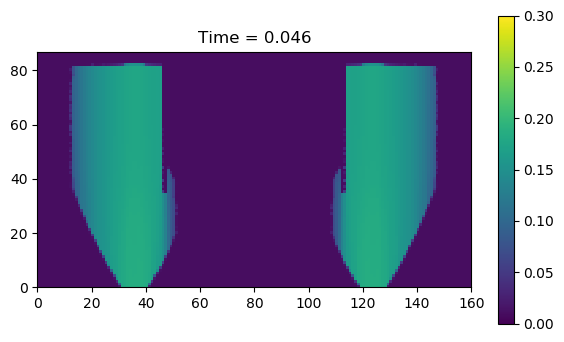

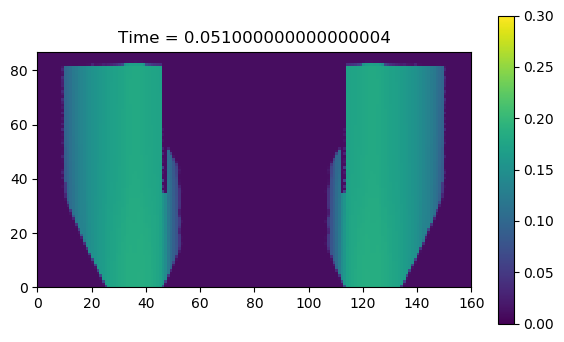

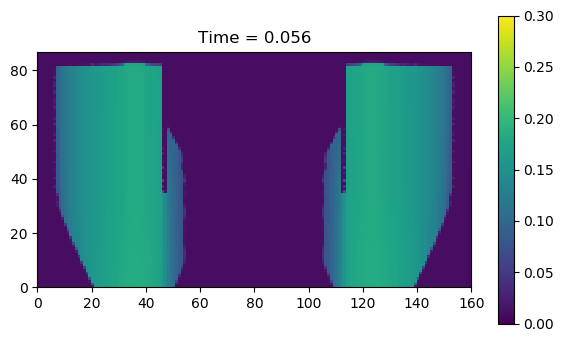

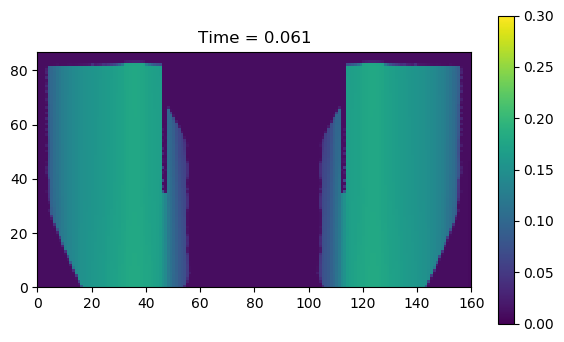

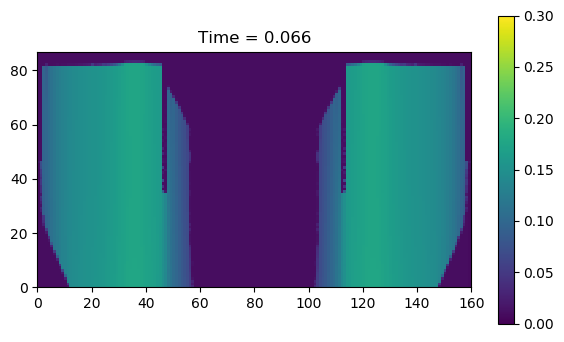

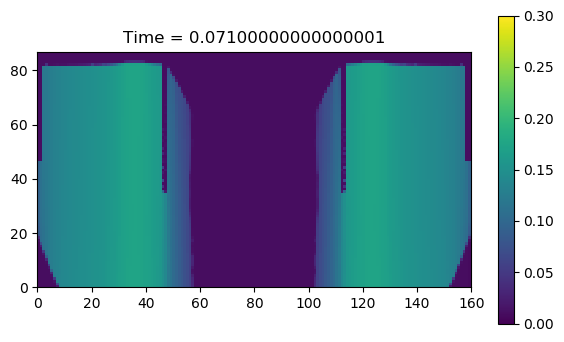

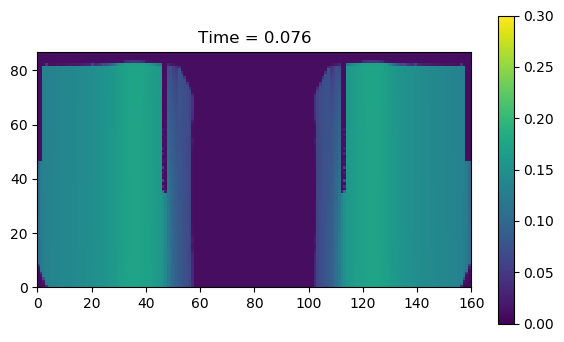

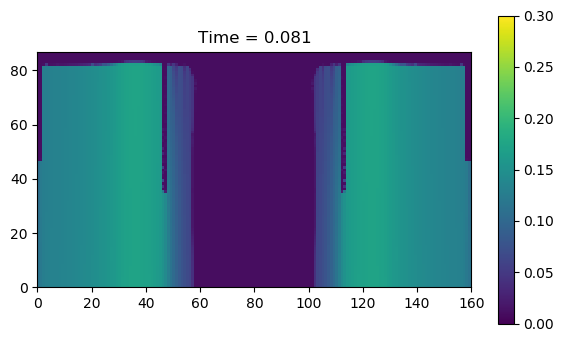

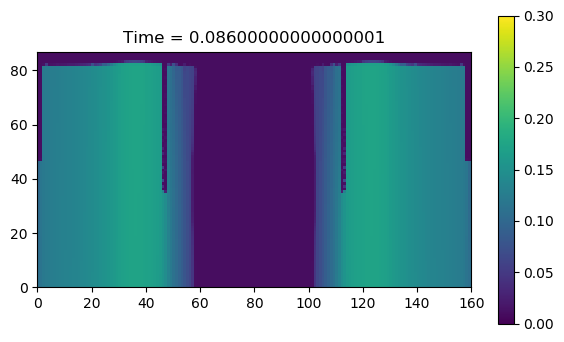

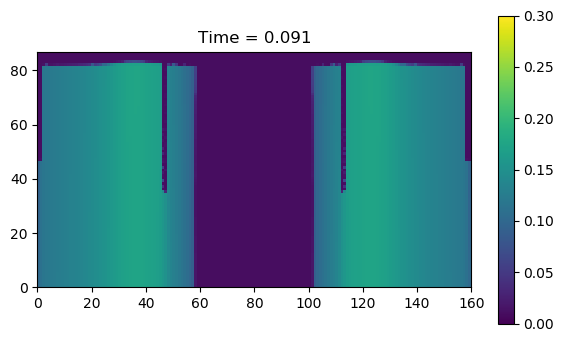

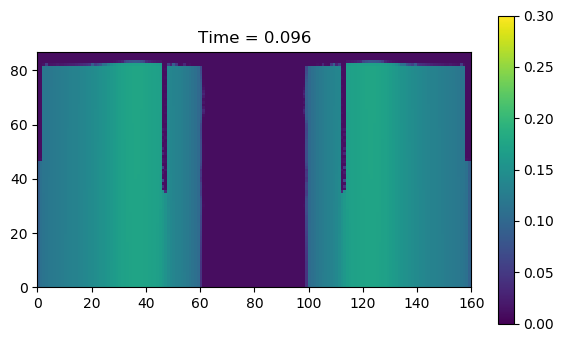

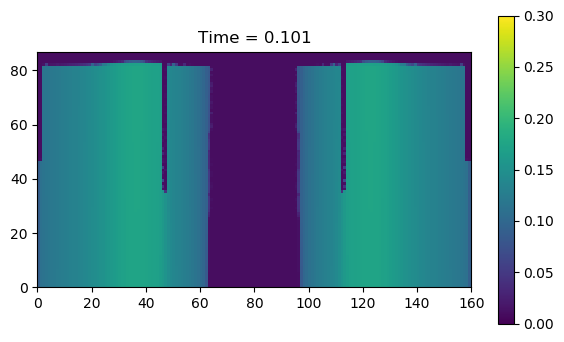

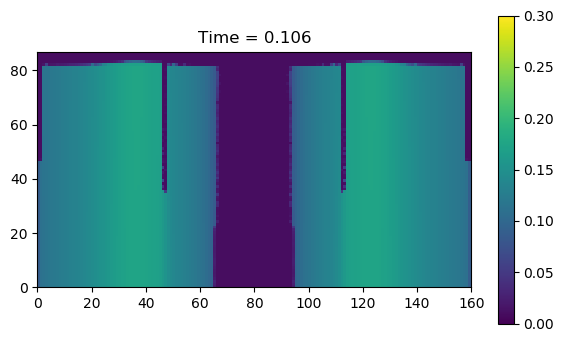

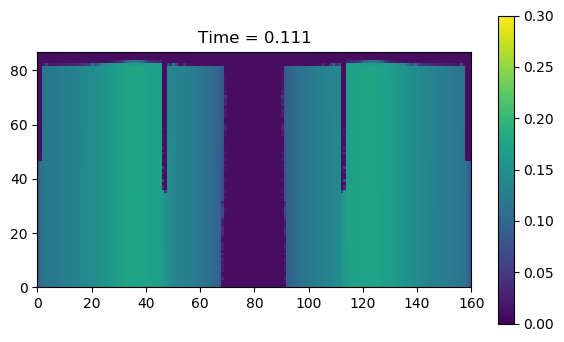

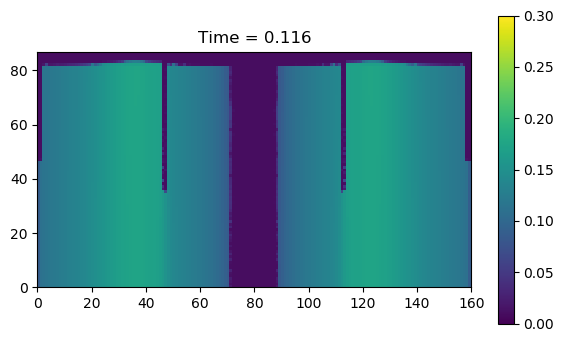

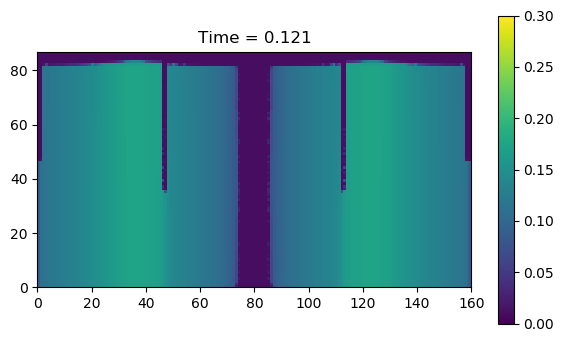

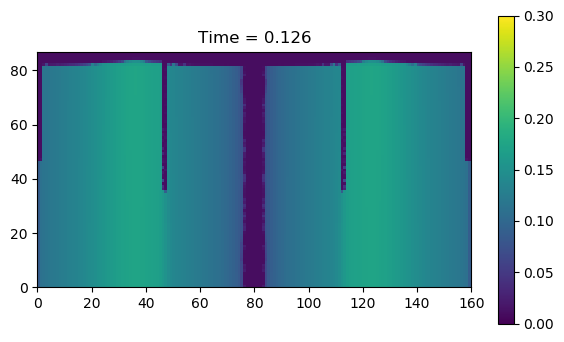

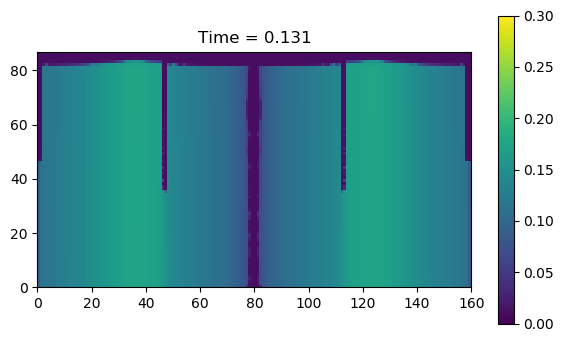

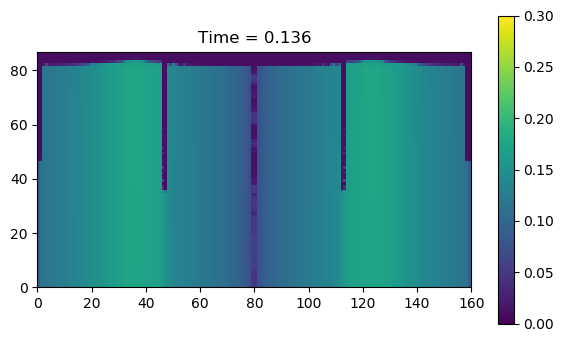

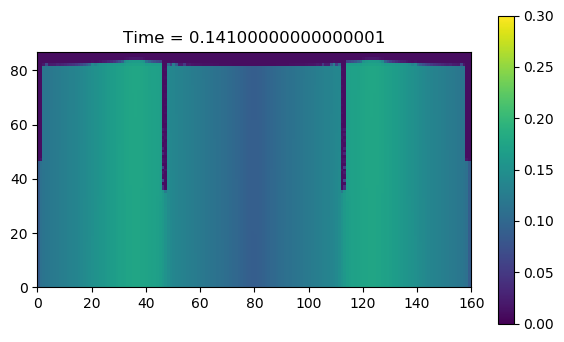

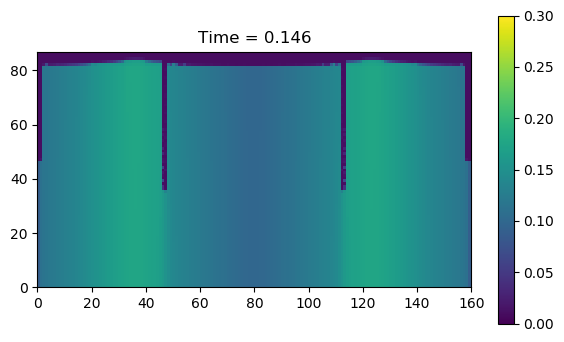

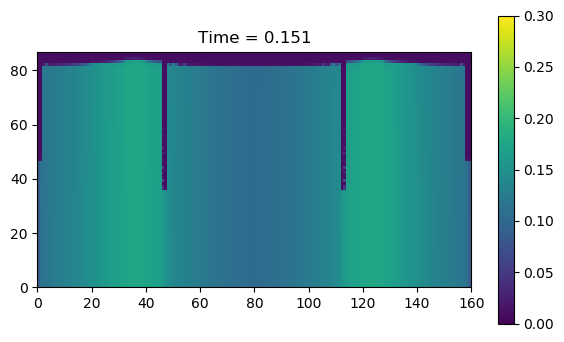

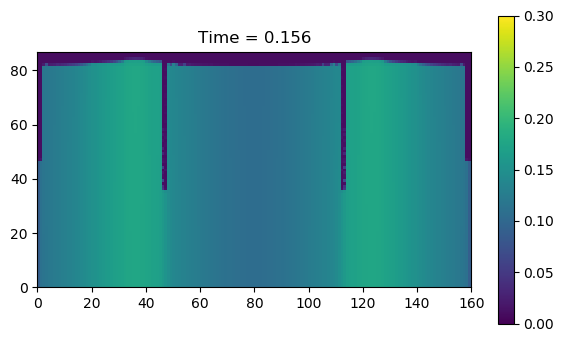

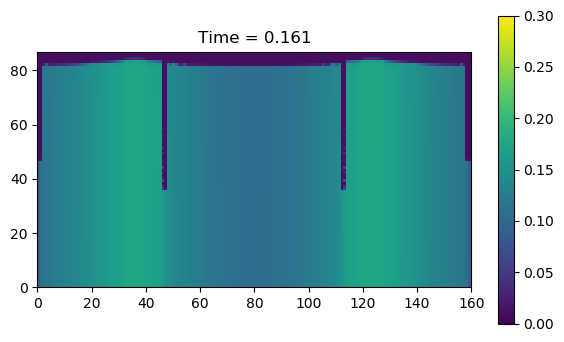

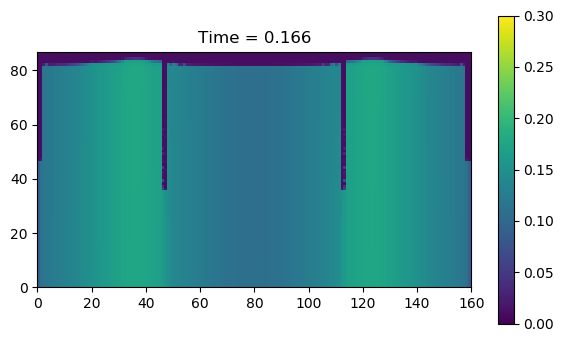

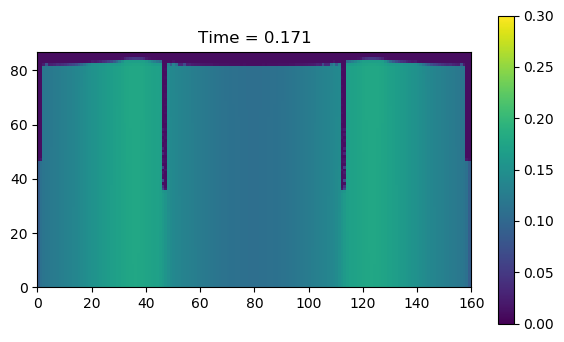

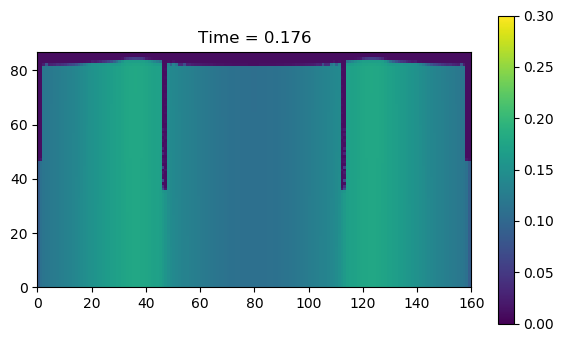

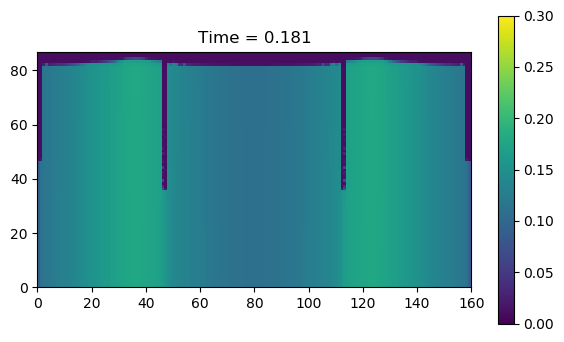

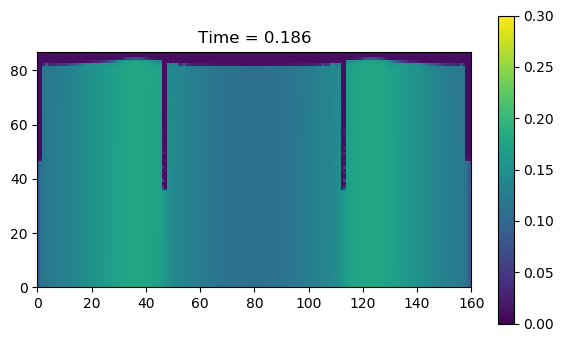

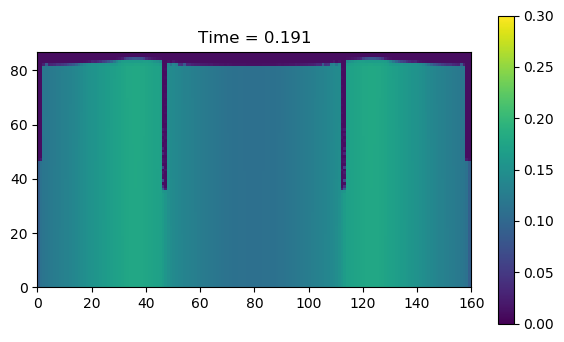

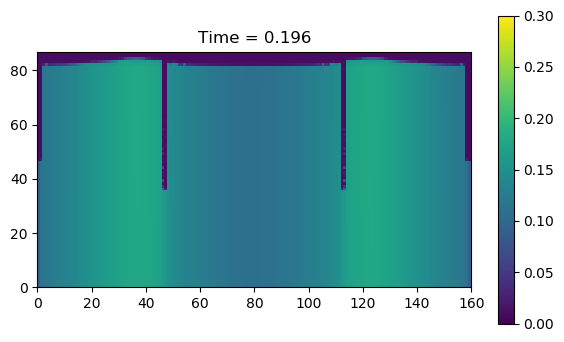

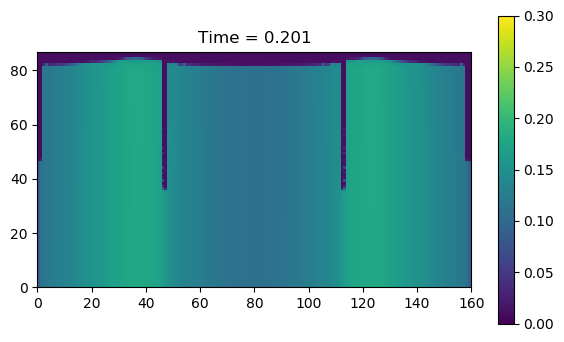

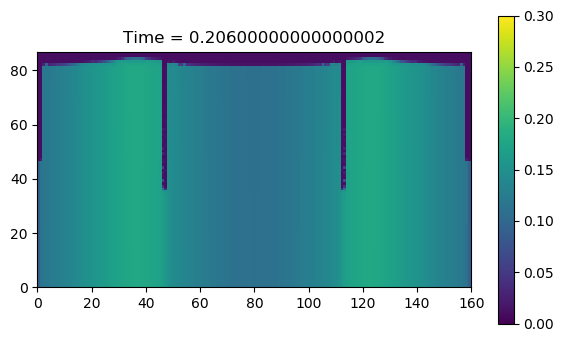

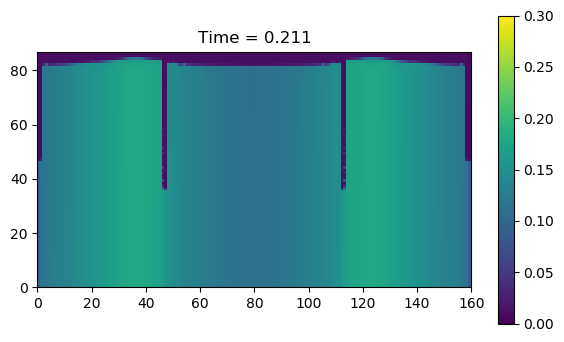

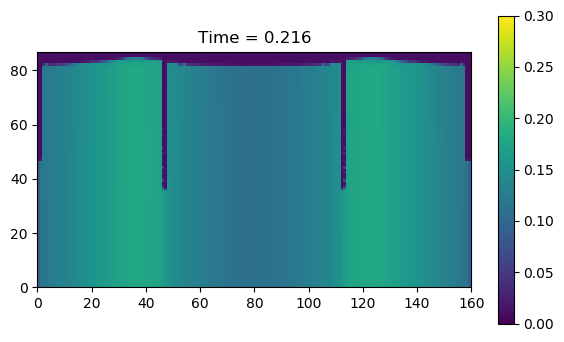

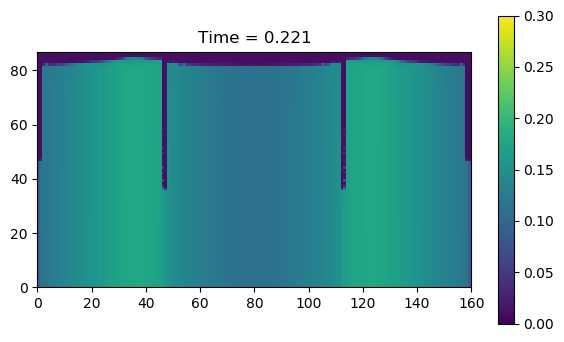

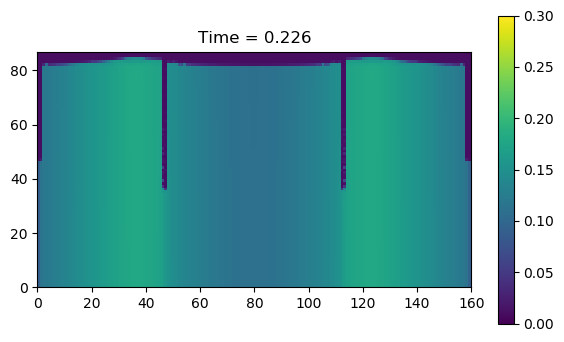

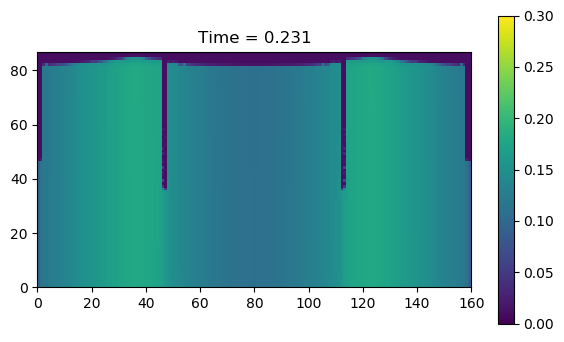

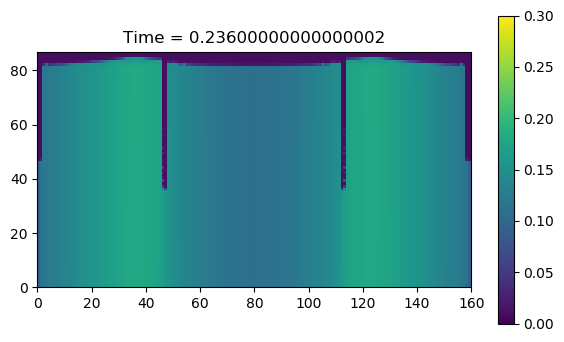

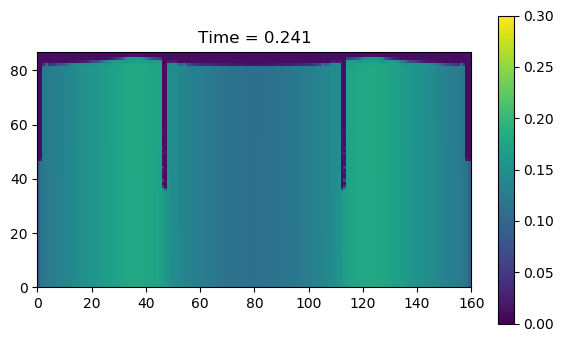

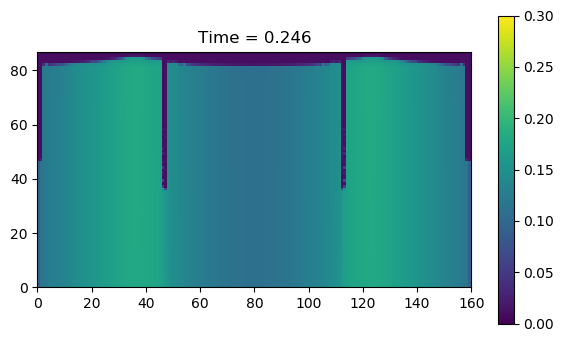

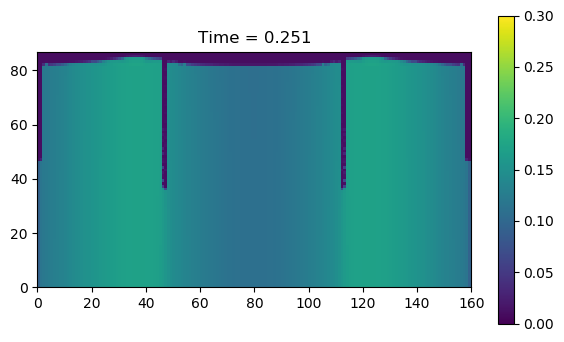

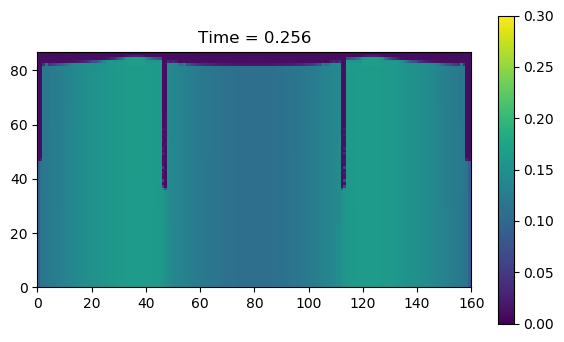

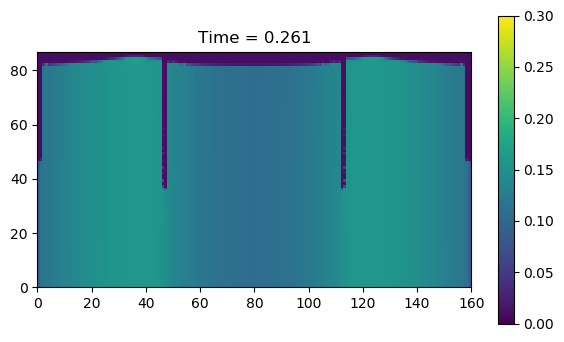

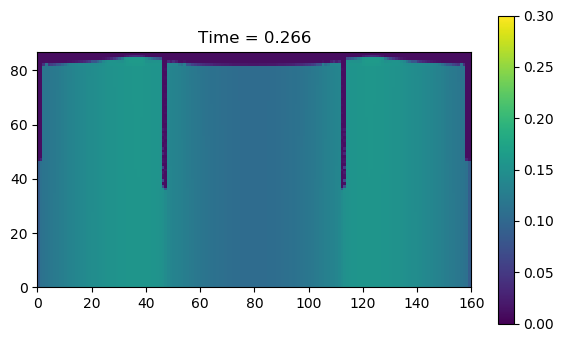

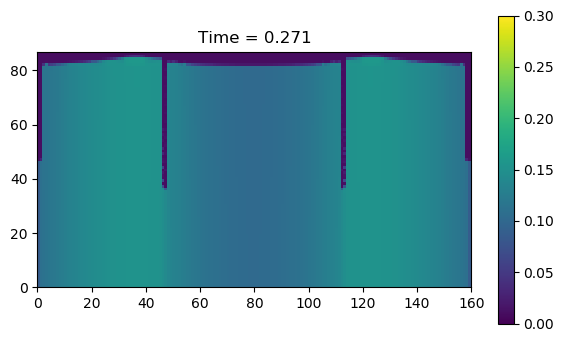

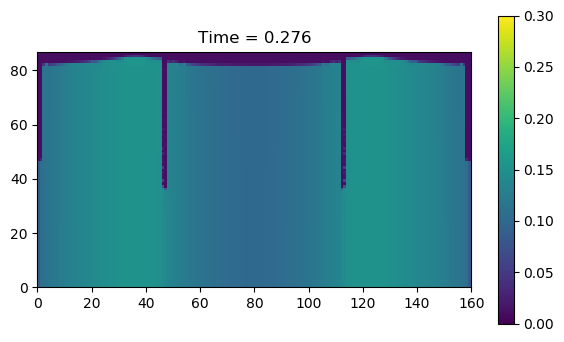

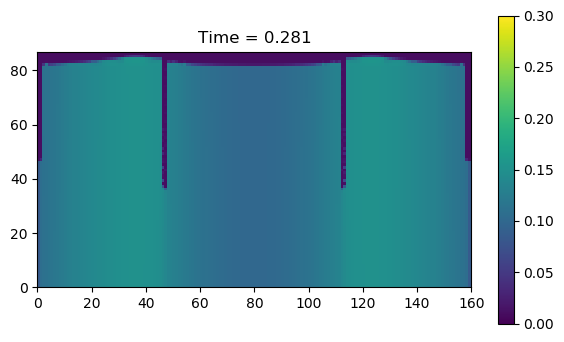

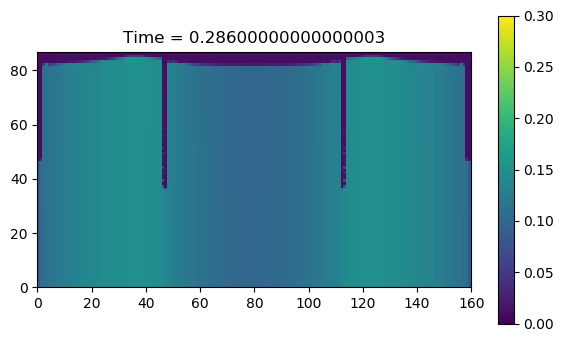

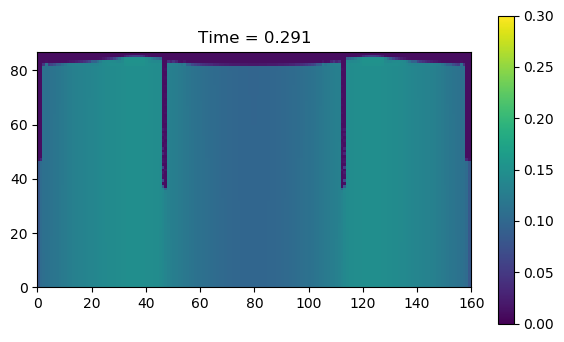

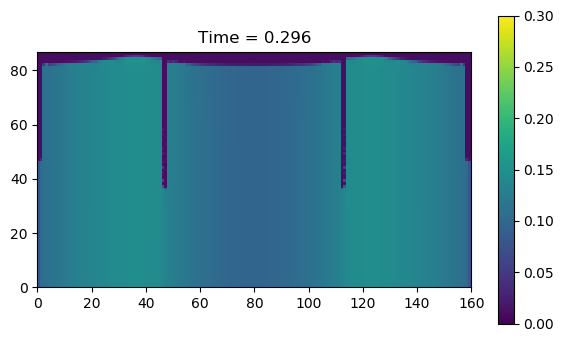

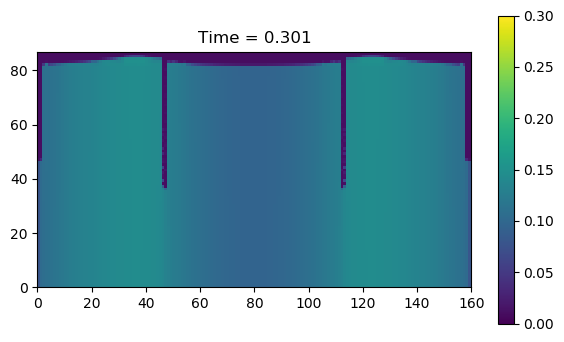

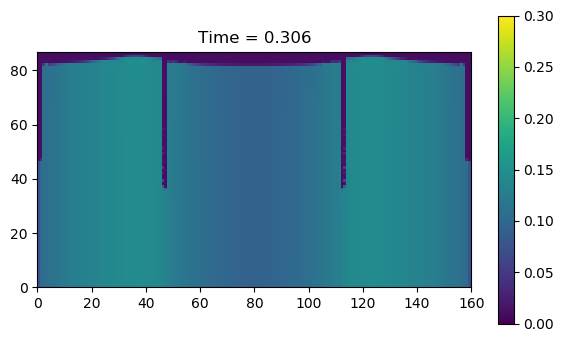

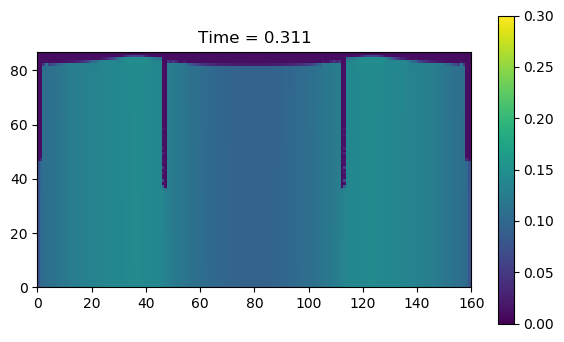

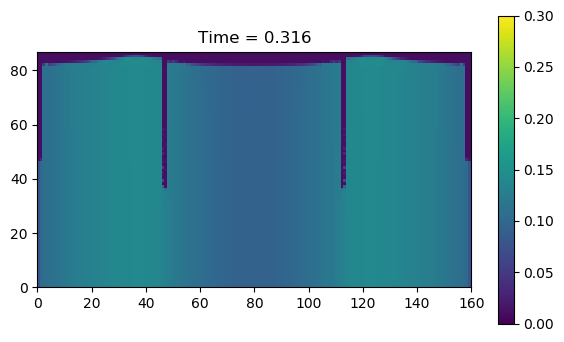

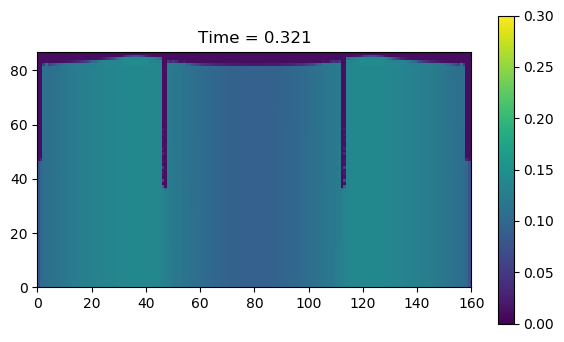

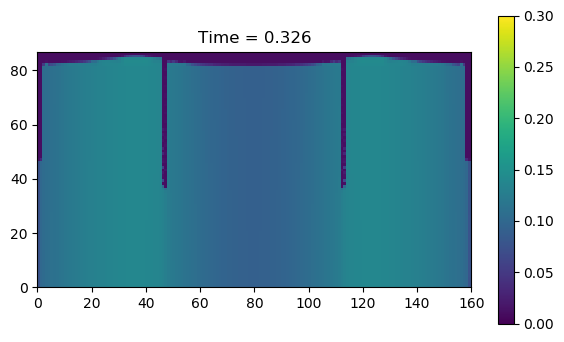

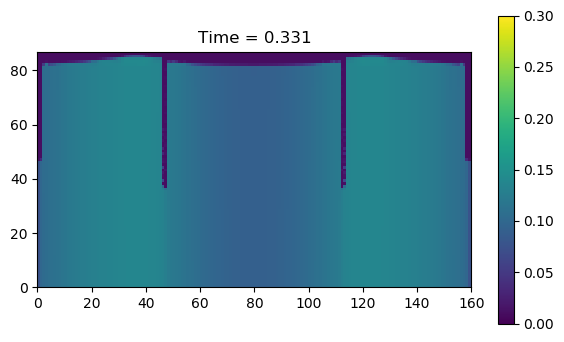

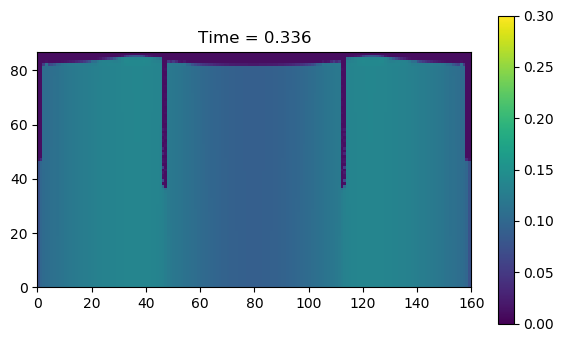

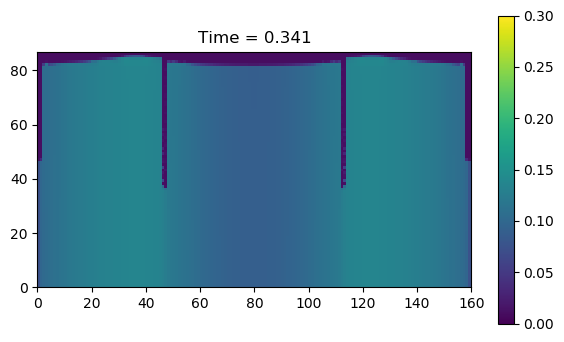

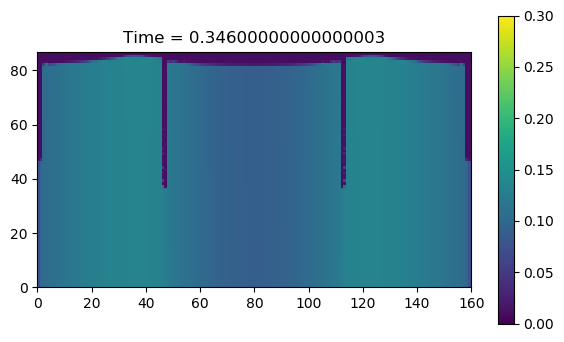

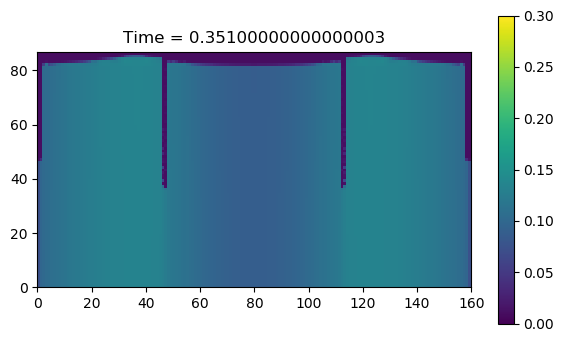

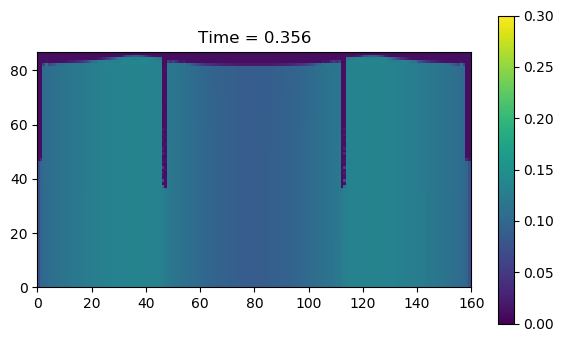

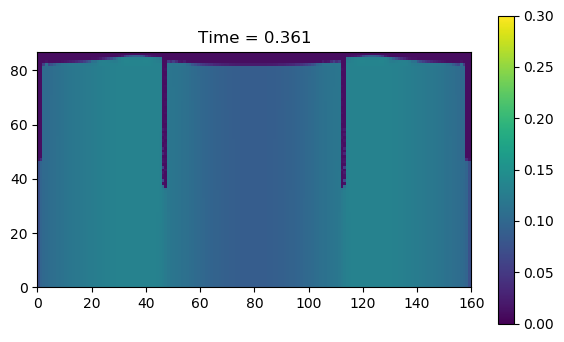

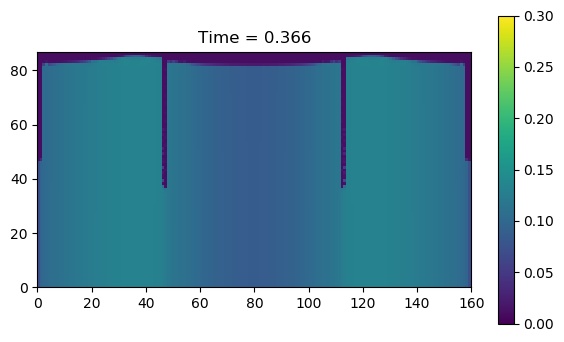

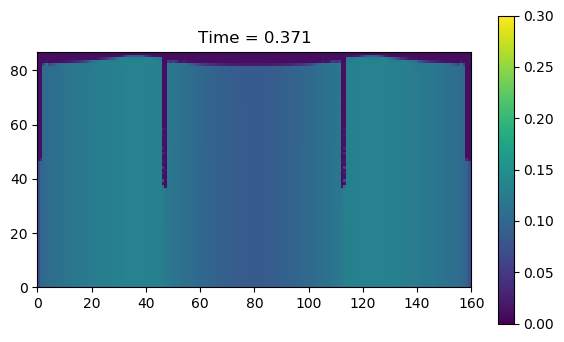

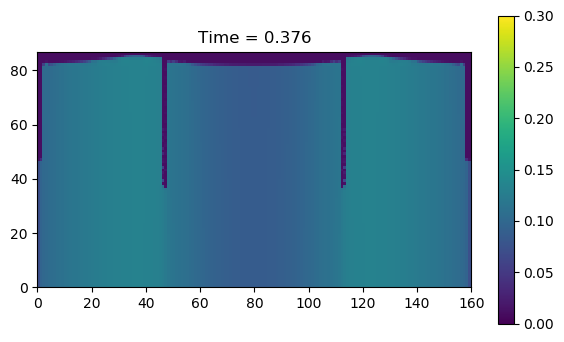

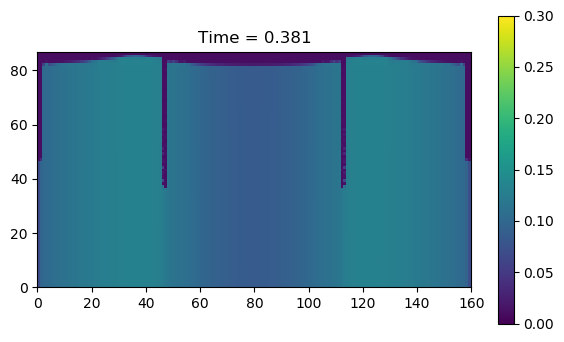

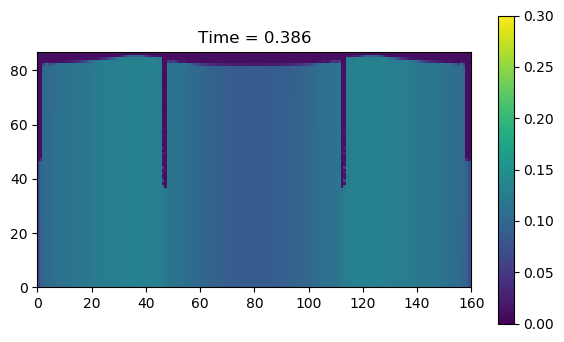

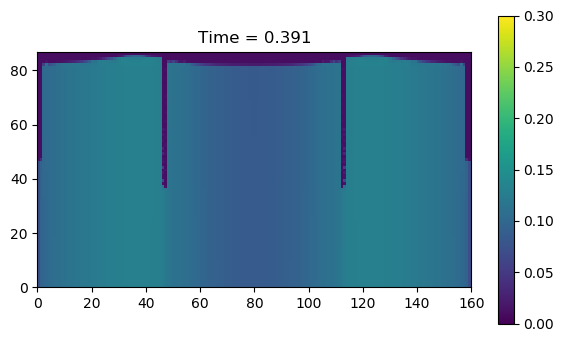

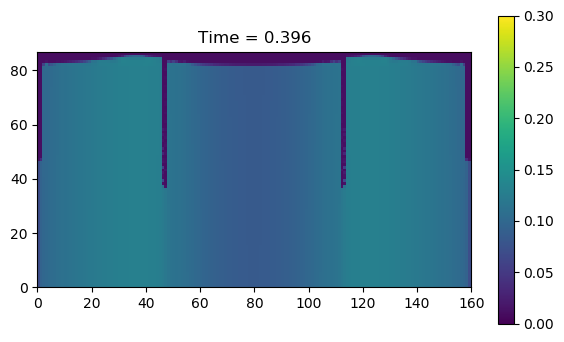

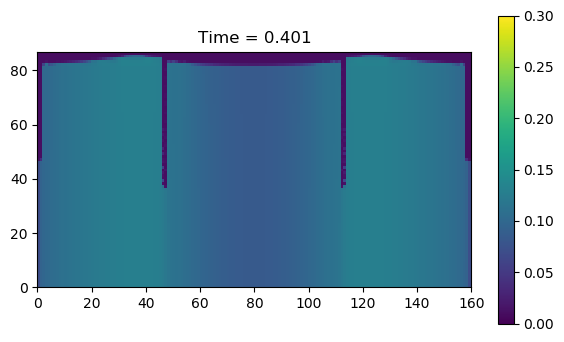

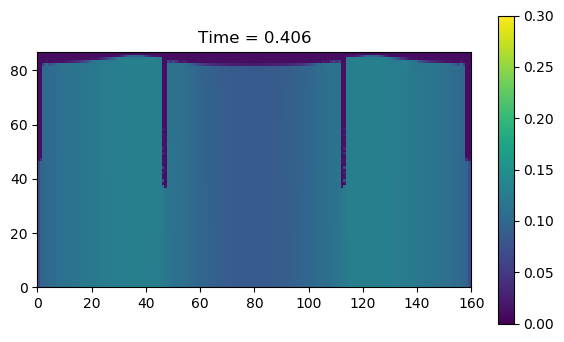

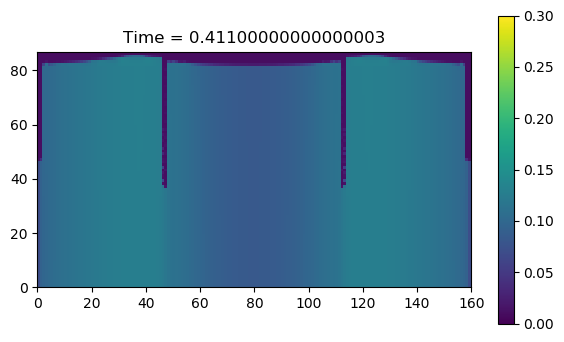

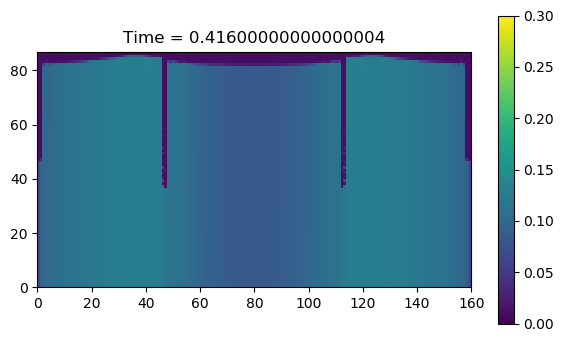

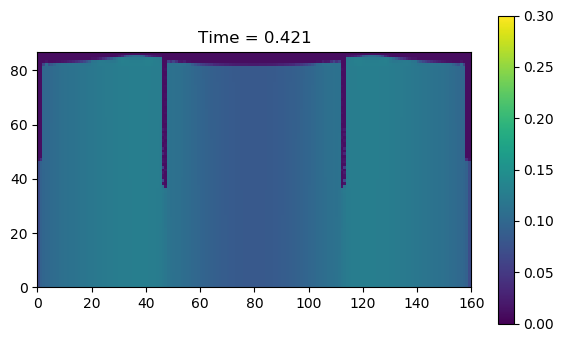

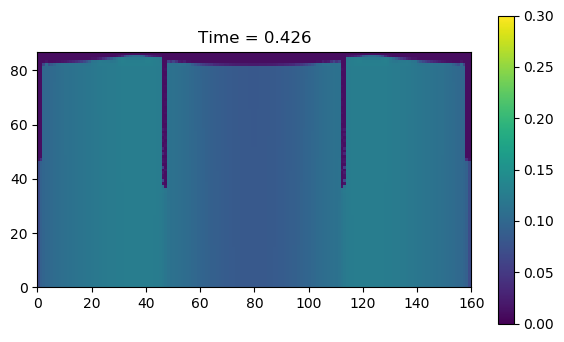

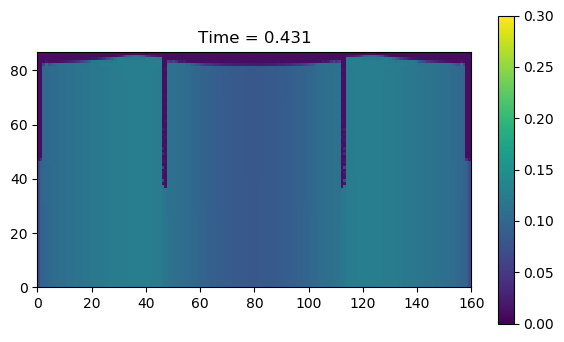

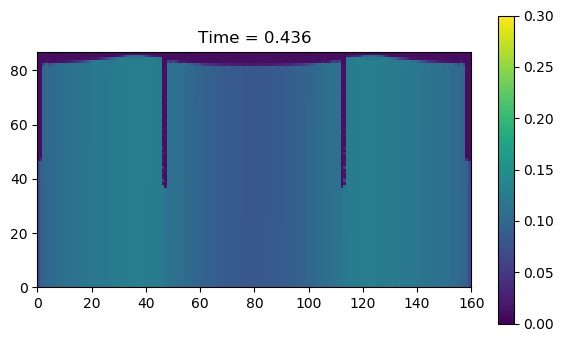

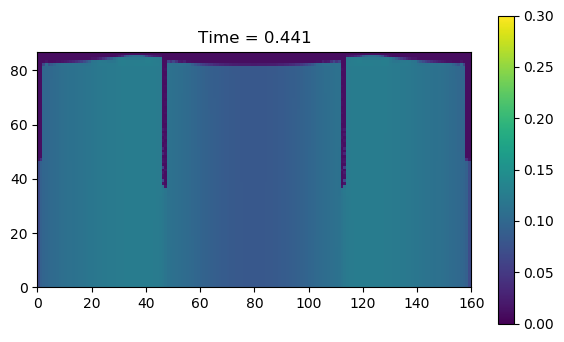

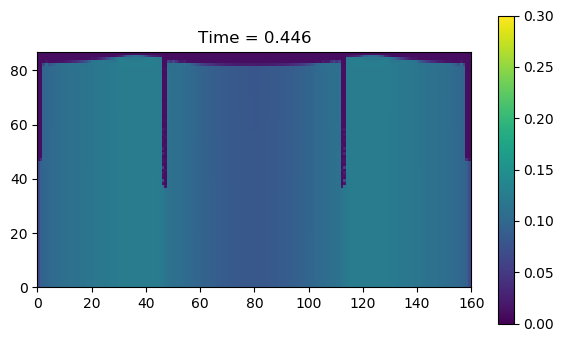

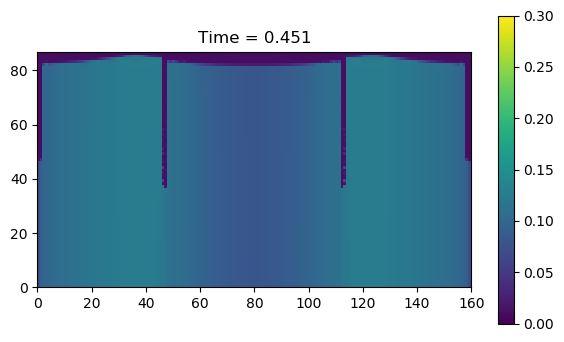

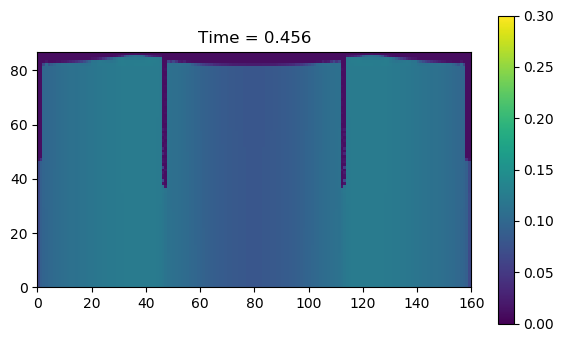

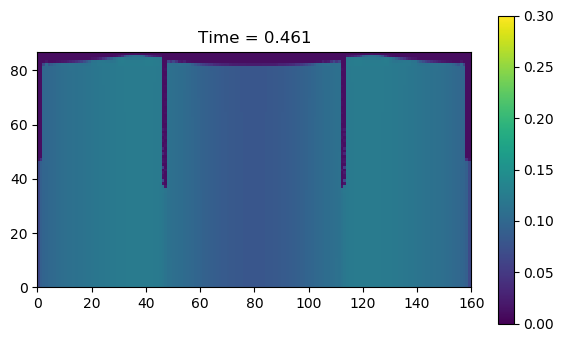

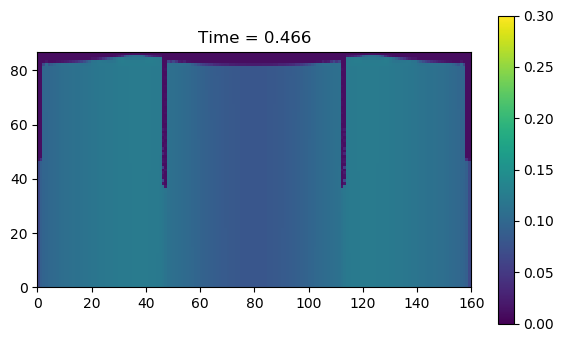

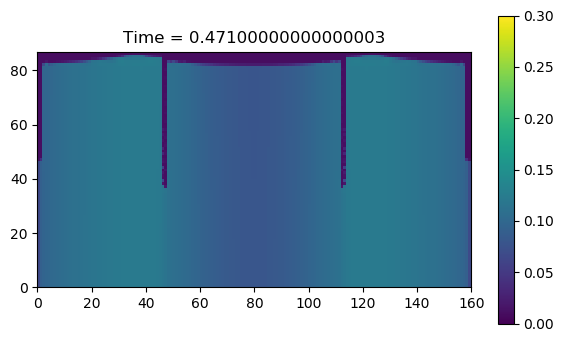

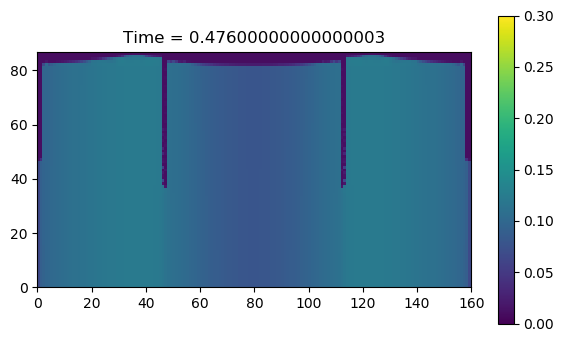

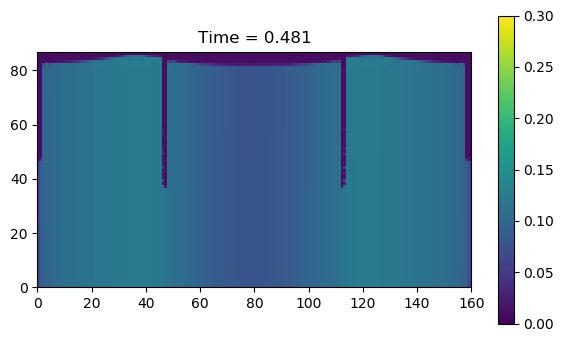

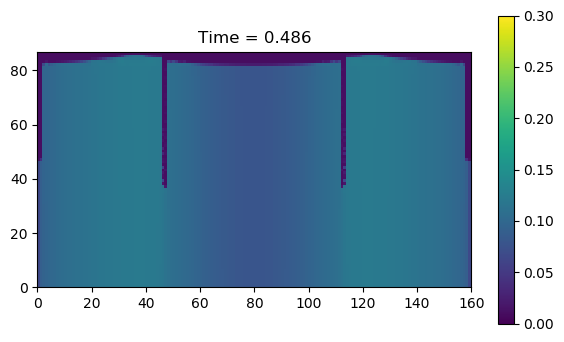

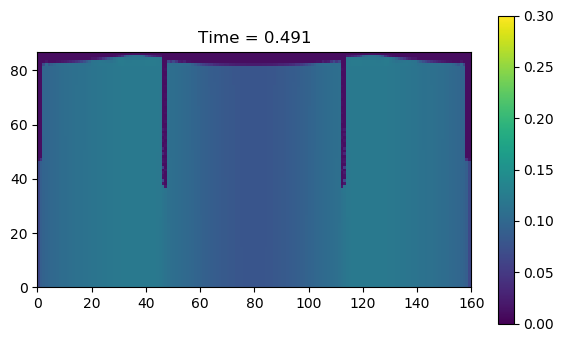

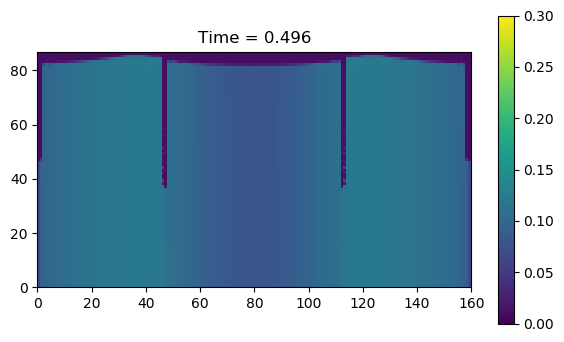

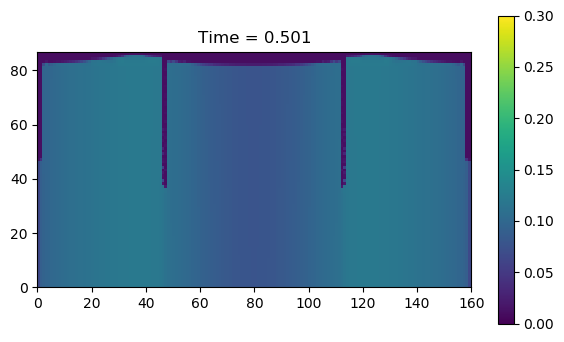

In [211]:

for i in 1:5:size(Er_t)[2]
    time_shown = i*dt
    Er_half = Er_t[:,i]
    T_half = (Er_half/a).^.25
    T_plot = reshape(T_half,Nr,Nz)
    figure(figsize=(7,4))
    title("Time = $(time_shown)")
    pcolormesh(T_plot, vmin=0, vmax = 0.3)
    colorbar()
    axis("scaled") 
end
    

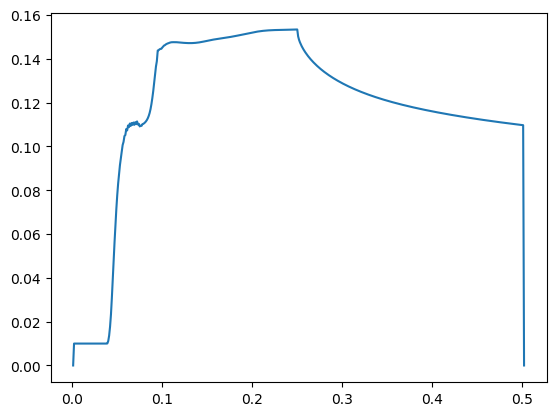

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x147f56ed0>

In [212]:
T_mid = zeros(size(Er_t)[2])
for i in 1:size(Er_t)[2]
    time_shown = i*dt
    Er_half = Er_t[:,i]
    T_half = (Er_half/a).^.25
    T_plot = reshape(T_half,Nr,Nz)
    T_mid[i] = mean(T_plot[1:10,40:60])
    
end
plot(dt*(1:size(Er_t)[2]), T_mid)

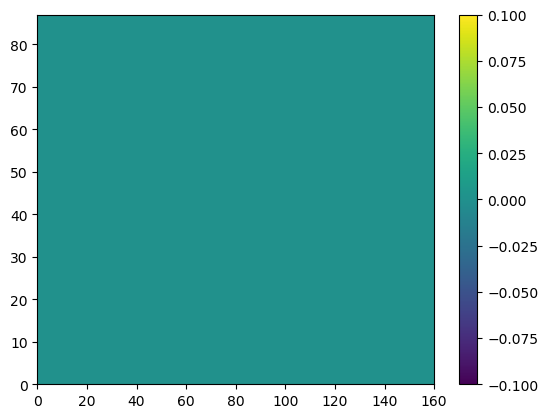

PyObject <matplotlib.colorbar.Colorbar object at 0x152cc4810>

In [197]:
pcolormesh(T_plot-flipdim(T_plot,2))
colorbar()